# iSNV analysis for POWV cultures 
#### Last updated: 1/31/2019

In [31]:
# importing any libraries we'll need for this script
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from pathlib import Path
from matplotlib.colors import LogNorm
from matplotlib.mlab import bivariate_normal
import math

%matplotlib inline  

## Importing and cleaning data from vphaser reports

As for setup, I saved all vphaser outputs into a designated folder on my computer. I also went through and manually found how shifted the isnv bp calls were relative to the L2b reference (HM440559.1), and made a list of how far they needed to be shifted. This shouldn't be necessary once we work out viral-ngs kinks. (but for now, note: confirm that the order is correct for the order in which the files will be imported - which should be alphanumeric)

In [32]:
# path to that folder where vphaser files are stored
data_pth = Path('./Desktop/04_intrahost/')
files = [f for f in sorted(os.listdir(data_pth)) if f.endswith('.txt')]
# number of bases to be shifted
num_bases = [3,3,18,2,3,3,3,4,4,0,4,3,4,4,2]

In [33]:
# function for importing vphaser files into dataframes, filtering for snps only, setting a 
# frequency cutoff, and adjusting the frame to match position of the reference 
def read_file(f, num_bases):
    # importing isnv files into dataframe
    lines = open(data_pth/f).readlines()
    lines = [_.split('\t') for _ in lines]
    d = pd.DataFrame(lines)
    # filters for snps, so we're not including insertions or deletions
    d = d[d[5] == 'snp']
    #changes basepairs and %frequency to data type float so that they can manipulated/plotted 
    d[[6]] = d[[6]].astype(float)
    d[[1]] = d[[1]].astype(float)
    #sets cutoff for isnv frequency at 1% (you can change this to whatever you want)
    d = d[d[6]>1]
    #changes basepair call such that it matches reference exactly (they were all off by a bit)
    d[1] = d[1]+num_bases
    # prints order that files are being processed to confirm num_bases are in correct order
    print(data_pth/f)
    return d

In [34]:
# run the function above to import/clean data from each file in our specified folder
# each sample will be its own dataframe referenced in the result_dict dictionary
result_dict = {f: read_file(f, n) for f, n in zip(files, num_bases)}

# printed below is the order in which the files were processed

Desktop/04_intrahost/vphaser2.CSUcx1.txt
Desktop/04_intrahost/vphaser2.CSUcx10.txt
Desktop/04_intrahost/vphaser2.CSUcx11.txt
Desktop/04_intrahost/vphaser2.CSUcx12.txt
Desktop/04_intrahost/vphaser2.CSUcx13.txt
Desktop/04_intrahost/vphaser2.CSUcx14.txt
Desktop/04_intrahost/vphaser2.CSUcx15.txt
Desktop/04_intrahost/vphaser2.CSUcx2.txt
Desktop/04_intrahost/vphaser2.CSUcx3.txt
Desktop/04_intrahost/vphaser2.CSUcx4.txt
Desktop/04_intrahost/vphaser2.CSUcx5.txt
Desktop/04_intrahost/vphaser2.CSUcx6.txt
Desktop/04_intrahost/vphaser2.CSUcx7.txt
Desktop/04_intrahost/vphaser2.CSUcx8.txt
Desktop/04_intrahost/vphaser2.CSUcx9.txt


#### Check the format of the data
We now have result_dict, which is a dictionary of dataframes. This means there's a table for each sample with all info from vphaser, and the key to access it is that sample's vphaser filename

For example, maybe we want to check out the results for CSUcx10 

In [35]:
# removing the '.head()' will show the whole table, rather than the first 5 entries
result_dict['vphaser2.CSUcx10.txt'].head()

,0,1,2,3,4,5,6,7,8,9
4,CSUcx10-1,351.0,C,A,0.05502,snp,13.57640,A:21995:16384:12340:8829:9655:7556:0.07031,C:3376:2653:1838:1412:1538:1241:0.07031\n,None
23,CSUcx10-1,750.0,T,G,0.001564,snp,12.21530,G:23915:19405:13651:11174:10264:8231:0.6268,T:3189:2824:1808:1614:1381:1210:0.5591,A:8:7:6:6:2:1:0.1147\n
28,CSUcx10-1,936.0,T,C,0.07211,snp,12.73340,C:20821:27646:11794:15917:9027:11729:0.6619,T:2959:4113:1726:2337:1233:1776:0.6619\n,None
36,CSUcx10-1,1098.0,A,G,0.05747,snp,13.15540,G:17620:23058:9973:13318:7647:9740:0.7612,A:2748:3414:1558:1983:1190:1431:0.7612\n,None
37,CSUcx10-1,1111.0,G,A,0.3602,snp,2.07027,A:18683:25687:10553:14819:8130:10869:0.03873,G:381:557:236:332:145:225:0.03873\n,None


Note that the dataframe below is empty, because CSUcx4 didn't have any SNPs >1% frequency found by vphaser

In [36]:
result_dict['vphaser2.CSUcx4.txt'].head()

,0,1,2,3,4,5,6,7,8


How many iSNVs are in each sample? We can check how many rows are in each dataframe

In [37]:
[f"file {k} has {v.shape[0]} iSNVs!" for k, v in result_dict.items()]

['file vphaser2.CSUcx1.txt has 20 iSNVs!',
 'file vphaser2.CSUcx10.txt has 33 iSNVs!',
 'file vphaser2.CSUcx11.txt has 5 iSNVs!',
 'file vphaser2.CSUcx12.txt has 5 iSNVs!',
 'file vphaser2.CSUcx13.txt has 7 iSNVs!',
 'file vphaser2.CSUcx14.txt has 3 iSNVs!',
 'file vphaser2.CSUcx15.txt has 31 iSNVs!',
 'file vphaser2.CSUcx2.txt has 34 iSNVs!',
 'file vphaser2.CSUcx3.txt has 2 iSNVs!',
 'file vphaser2.CSUcx4.txt has 0 iSNVs!',
 'file vphaser2.CSUcx5.txt has 5 iSNVs!',
 'file vphaser2.CSUcx6.txt has 7 iSNVs!',
 'file vphaser2.CSUcx7.txt has 4 iSNVs!',
 'file vphaser2.CSUcx8.txt has 11 iSNVs!',
 'file vphaser2.CSUcx9.txt has 14 iSNVs!']

## Exploring general landscape of iSNVs - plotting

### Plotting a scatterplot

In this format, we can plot all isnvs (above the frequency threshhold we set earlier) for each sample of interest - each unique sample can be colored and labeled however we want.

In [38]:
# function for plotting - must pass the isnv dictionary, a color map, and a legend map
def scatter_isnvs(isnv_dict,colormap,legend):
    # controls dimensions of figure
    plt.figure(figsize=(12,8))
    # plots every snp >1% frequency for each sample - color/legend title are dictated by colormap/legend
    for key,color in zip(isnv_dict,colormap):
        plt.scatter(isnv_dict[key][1],isnv_dict[key][6],color=color,alpha=0.3,s=20)
    # can commend out log scale on y axis if linear scale is preferable
    plt.yscale('log')
    plt.xlabel('POWV bp')
    plt.ylabel('% frequency of minor iSNV')
    # adds a legend, and controls where legend appears on plot
    plt.legend(legend,bbox_to_anchor=(1,1))
    return 

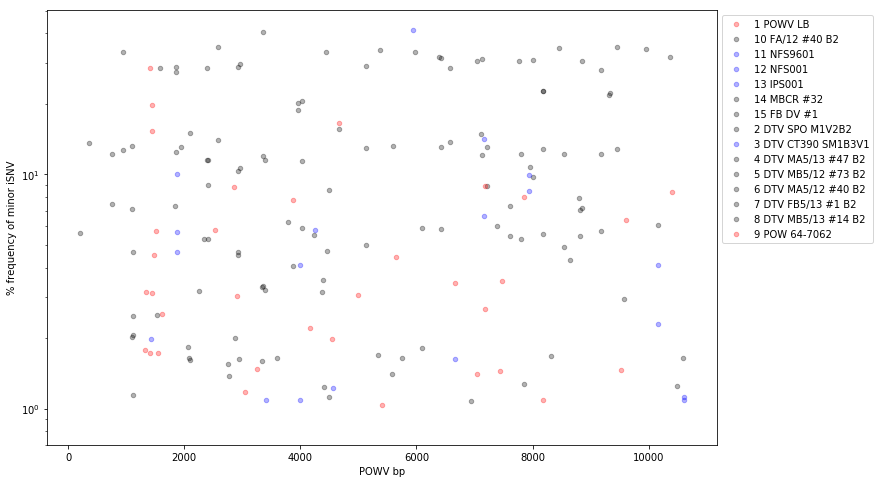

In [39]:
# can stipulate here if you want certain samples to be certain colors
# for example, uncommenting color map below would give different colors for different lineages
colormap = ['red','black','blue','blue','blue','black','black','black','blue','black','black',
            'black','black','black','red']
# the colormap commented out below is just all unique colors
#colormap = ['black','red','orange','white','yellow','green','blue','purple',
#            'black','grey','brown','pink','aqua','lime','olive']

# can stipulate here what names you want to give the samples
legend = ['1 POWV LB','10 FA/12 #40 B2','11 NFS9601','12 NFS001','13 IPS001','14 MBCR #32',
          '15 FB DV #1','2 DTV SPO M1V2B2','3 DTV CT390 SM1B3V1','4 DTV MA5/13 #47 B2',
          '5 DTV MB5/12 #73 B2','6 DTV MA5/12 #40 B2','7 DTV FB5/13 #1 B2','8 DTV MB5/13 #14 B2',
          '9 POW 64-7062']

# calls the function written in the block above to make this figure
scatter_isnvs(result_dict,colormap,legend)

### Fromatting and plotting a heatmap

#### Formatting

Now I'll reformat the data such that each row in the dataframe corresponds to a unique sample, and each column corresponds to a POWV bp - for everywhere that an SNP does not exist, there will be a zero, otherwise, the entry will be the frequency of the minor allele. I'm also making corresponding dataframes in the same format that will instead reflect the minor SNP and major SNP which I might use later.

In [40]:
# initializes dataframes of all zero that is in the dimensions we want (15 samples x 10839 bps)
binary_df = pd.DataFrame(np.zeros((15, 10839)))
freq_df = pd.DataFrame(np.zeros((15, 10839)))
minor_df = pd.DataFrame(np.zeros((15, 10839))).astype(str)
major_df = pd.DataFrame(np.zeros((15, 10839))).astype(str)

# I also want the samples to be clustered by their lineage for the heatmaps, so this'll be the order
order_of_samples = ['vphaser2.CSUcx1.txt','vphaser2.CSUcx9.txt','vphaser2.CSUcx10.txt',
                    'vphaser2.CSUcx15.txt', 'vphaser2.CSUcx2.txt','vphaser2.CSUcx14.txt',
                    'vphaser2.CSUcx5.txt','vphaser2.CSUcx7.txt', 'vphaser2.CSUcx8.txt',
                    'vphaser2.CSUcx4.txt',  'vphaser2.CSUcx6.txt','vphaser2.CSUcx12.txt', 
                    'vphaser2.CSUcx13.txt','vphaser2.CSUcx3.txt', 'vphaser2.CSUcx11.txt']
for i,key in zip(range(len(result_dict)),order_of_samples):
    freq_df.iloc[i][result_dict[key][1]] = result_dict[key][6]
    binary_df.iloc[i][result_dict[key][1]] = 1
    minor_df.iloc[i][result_dict[key][1]] = result_dict[key][2]
    major_df.iloc[i][result_dict[key][1]] = result_dict[key][3]

# renames the rows for the sample names    
freq_df = freq_df.rename(index={0:'1 POWV LB',1:'9 POW 64-7062',2:'10 FA/12 #40 B2',3:'15 FB DV #1',
                                4:'2 DTV SPO M1V2B2',5:'14 MBCR #32',6:'5 DTV MB5/12 #73 B2',
                                7:'7 DTV FB5/13 #1 B2',8:'8 DTV MB5/13 #14 B2',9:'4 DTV MA5/13 #47 B2',
                                10:'6 DTV MA5/12 #40 B2', 11:'12 NFS001',12:'13 IPS001',
                                13:'3 DTV CT390 SM1B3V1',14:'11 NFS9601'})
binary_df = binary_df.rename(index={0:'1 POWV LB',1:'9 POW 64-7062',2:'10 FA/12 #40 B2',3:'15 FB DV #1',
                                4:'2 DTV SPO M1V2B2',5:'14 MBCR #32',6:'5 DTV MB5/12 #73 B2',
                                7:'7 DTV FB5/13 #1 B2',8:'8 DTV MB5/13 #14 B2',9:'4 DTV MA5/13 #47 B2',
                                10:'6 DTV MA5/12 #40 B2', 11:'12 NFS001',12:'13 IPS001',
                                13:'3 DTV CT390 SM1B3V1',14:'11 NFS9601'})

What does this look like? Mostly it'll just be a lot of zero

In [41]:
freq_df

,0,1,2,3,4,5,6,7,8,9,...,10829,10830,10831,10832,10833,10834,10835,10836,10837,10838
1 POWV LB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9 POW 64-7062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 FA/12 #40 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15 FB DV #1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2 DTV SPO M1V2B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14 MBCR #32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5 DTV MB5/12 #73 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7 DTV FB5/13 #1 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8 DTV MB5/13 #14 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 DTV MA5/13 #47 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Plotting

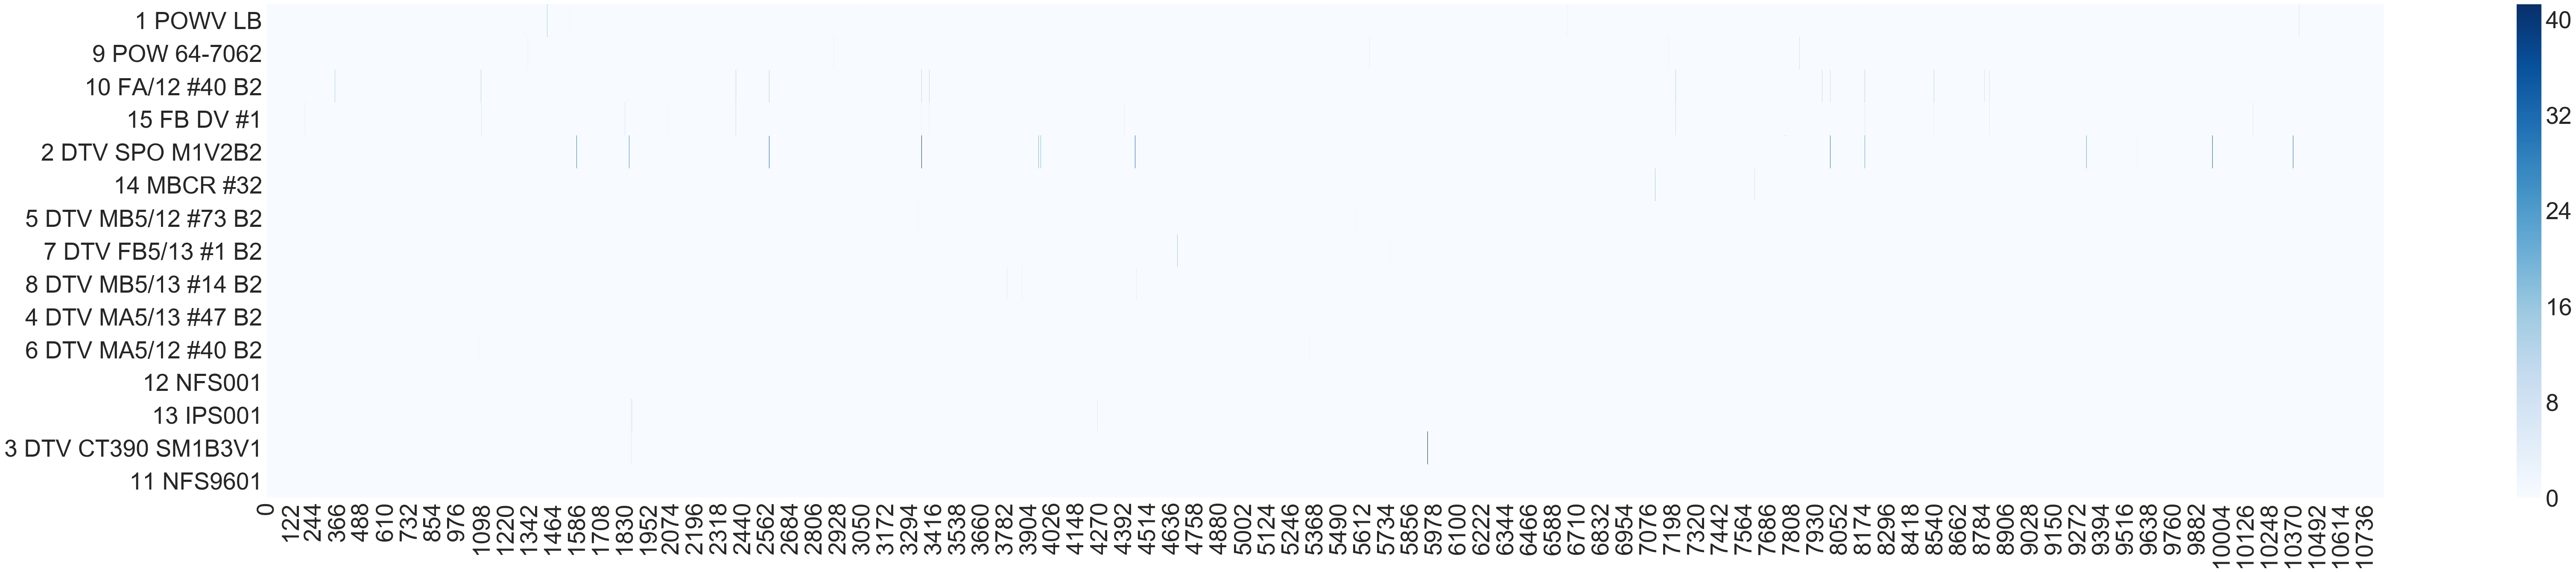

In [54]:
# we can plot a heatmap with the intensity of the color (or whatever color scheme you choose, can change it from blue)
# represents the frequency of the iSNV 
sns.set(font_scale=4) 
# sets the dimensions of the figure
plt.figure(figsize=(80,15))
# calls heatmap and sets the color scheme
f = sns.heatmap(freq_df, cmap="Blues")

In [55]:
# make a function that creates this kind of plot, but we can change the title, 
# size of the figure, and bp range
def heatmap_isnvs (df,gene_range,title,size):
    plt.figure(figsize=size)
    f = sns.heatmap(df, cmap="Blues")
    f.set_title(title,fontsize=60)
    f.set(xlim=gene_range)

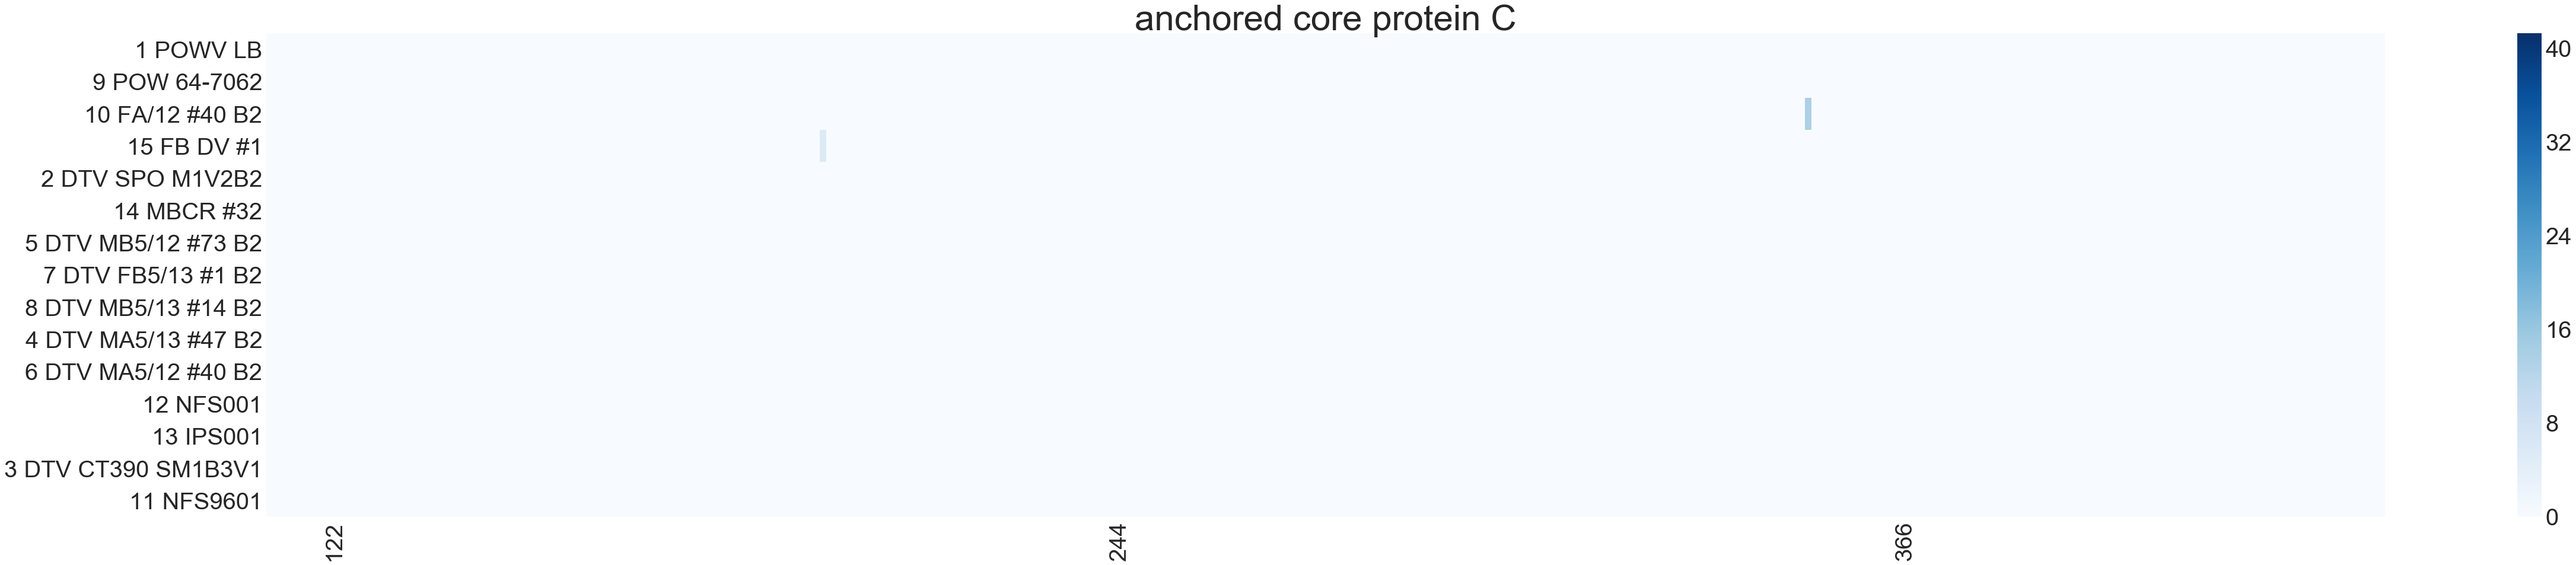

In [44]:
# now we can plot a heatmap like this for any desired gene range
heatmap_isnvs(freq_df,gene_range=(112,441),title='anchored core protein C',size=(80,15))

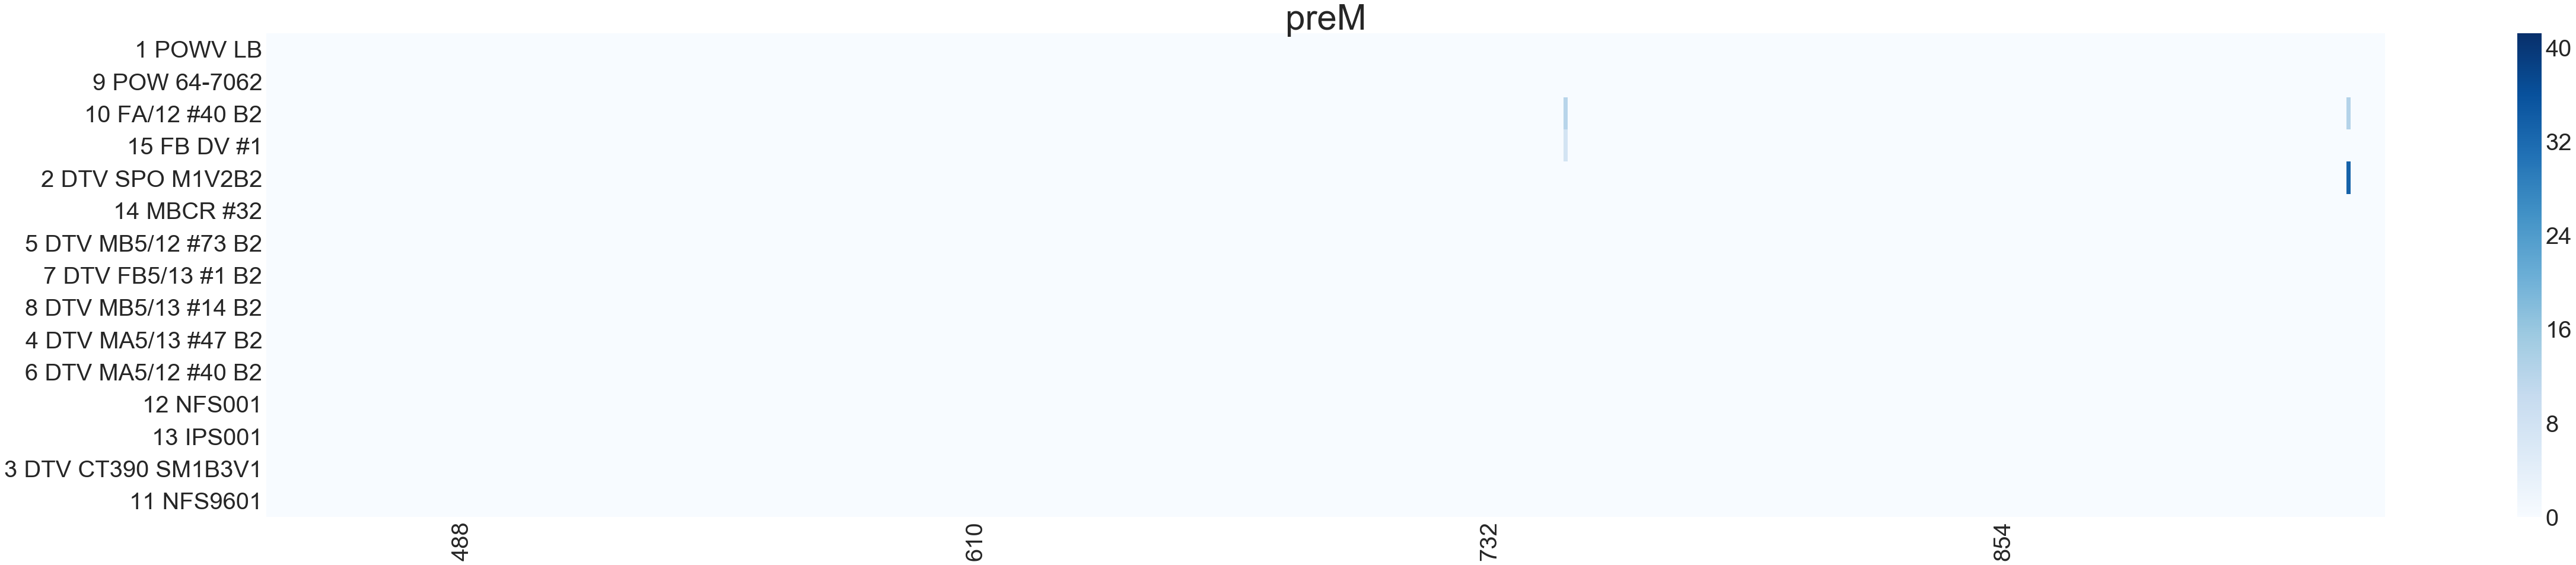

In [45]:
heatmap_isnvs(freq_df,gene_range=(442,945),title='preM',size=(80,15))

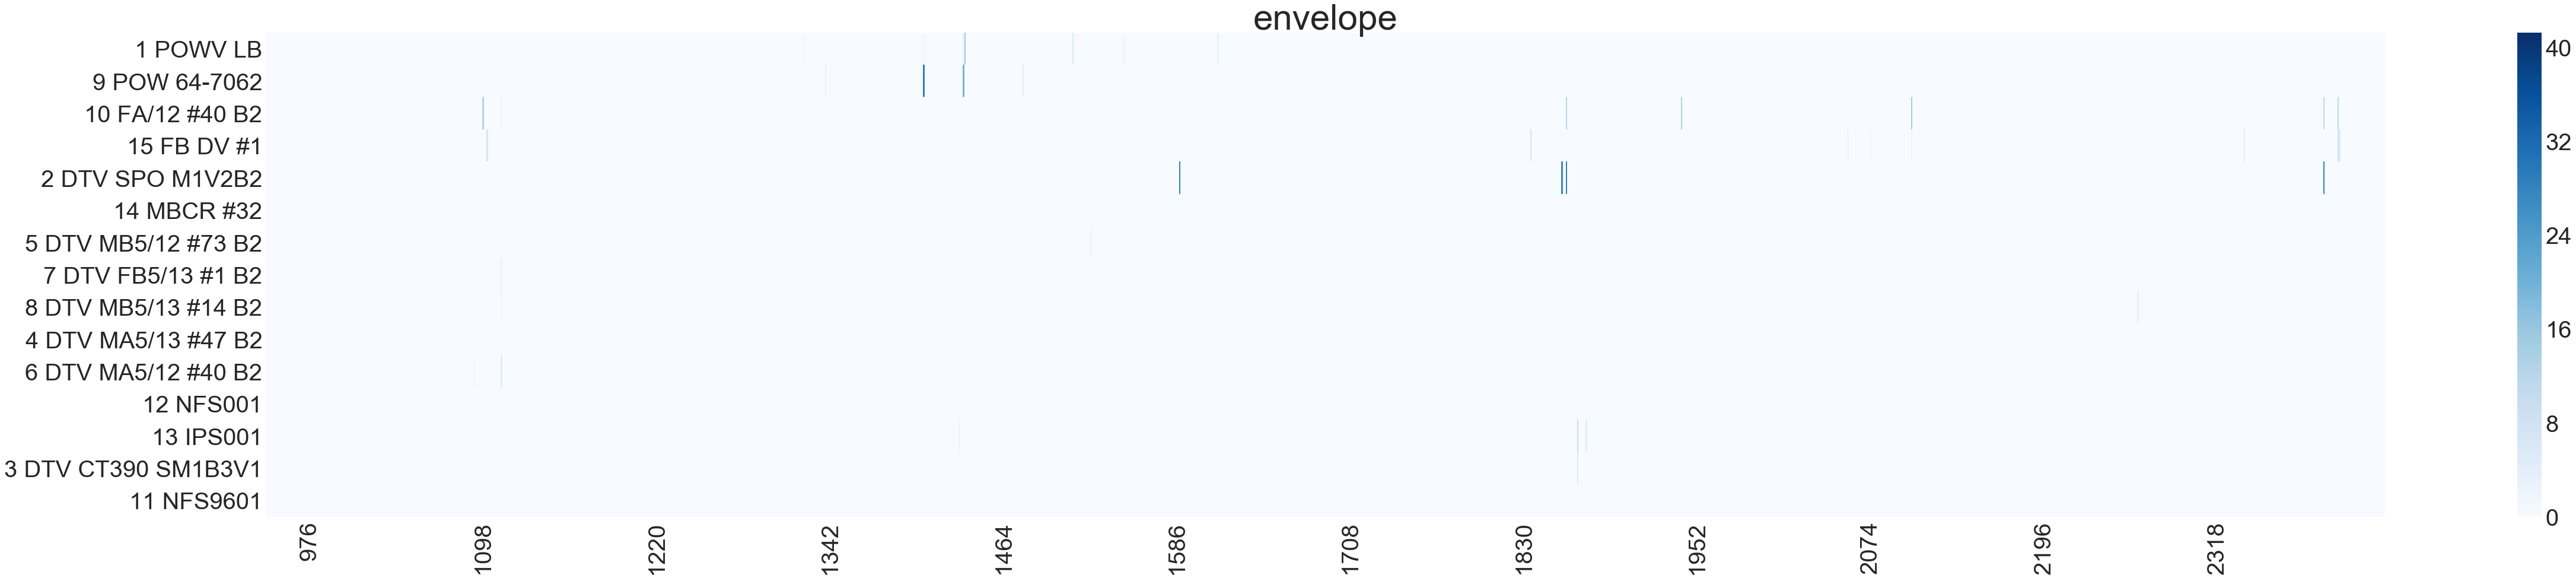

In [46]:
heatmap_isnvs(freq_df,gene_range=(946,2436),title='envelope',size=(80,15))

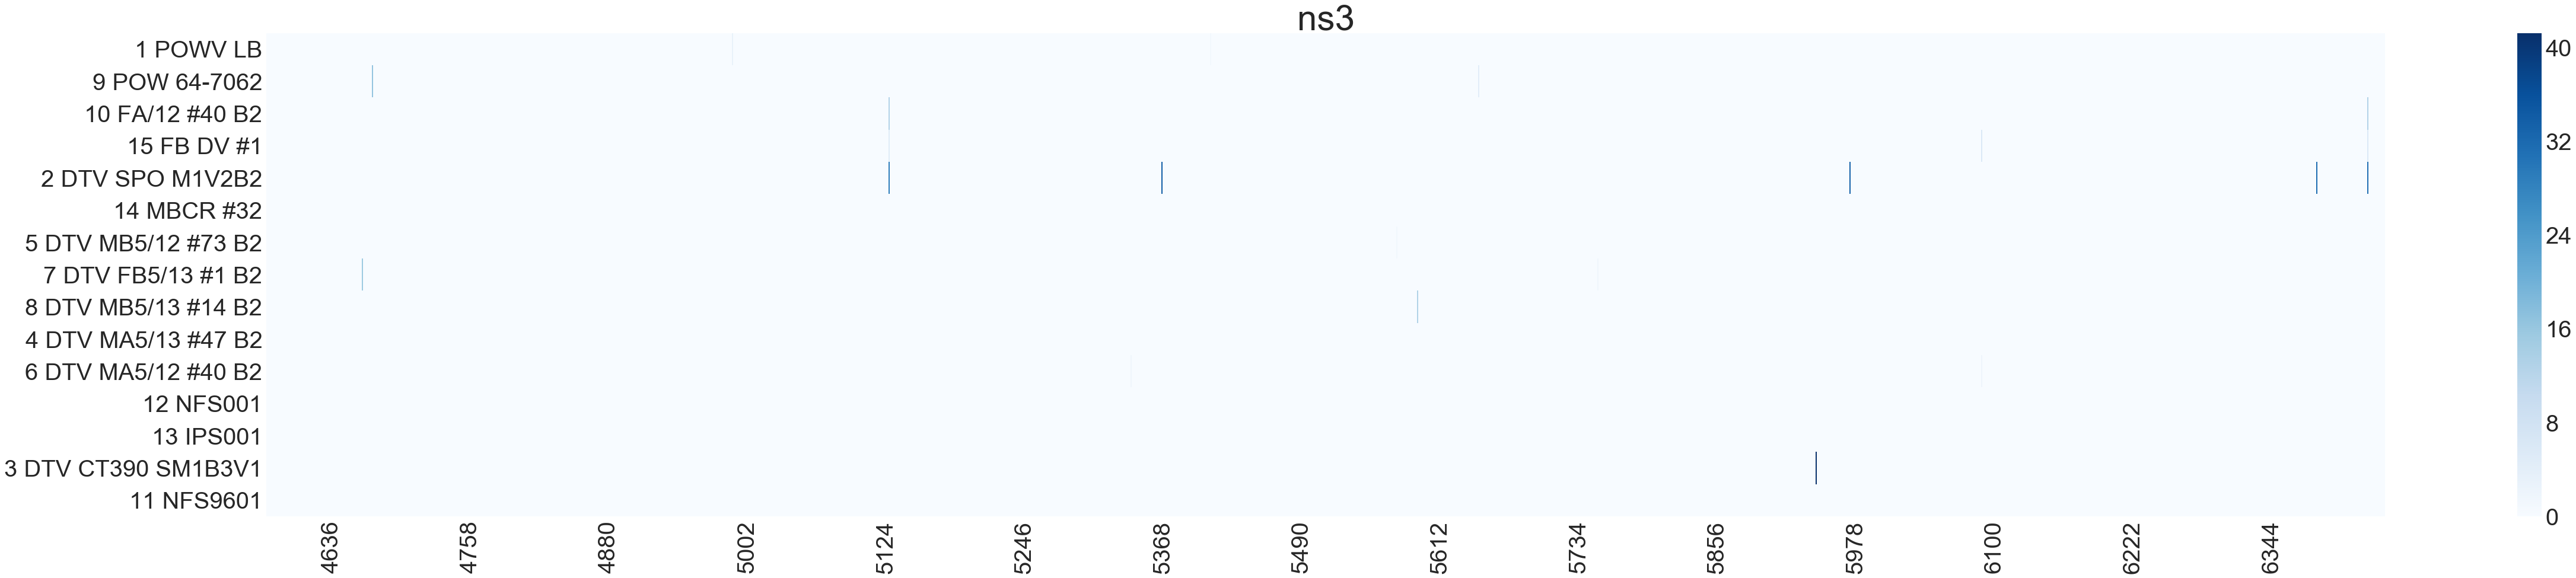

In [47]:
heatmap_isnvs(freq_df,gene_range=(4579,6444),title='ns3',size=(80,15))

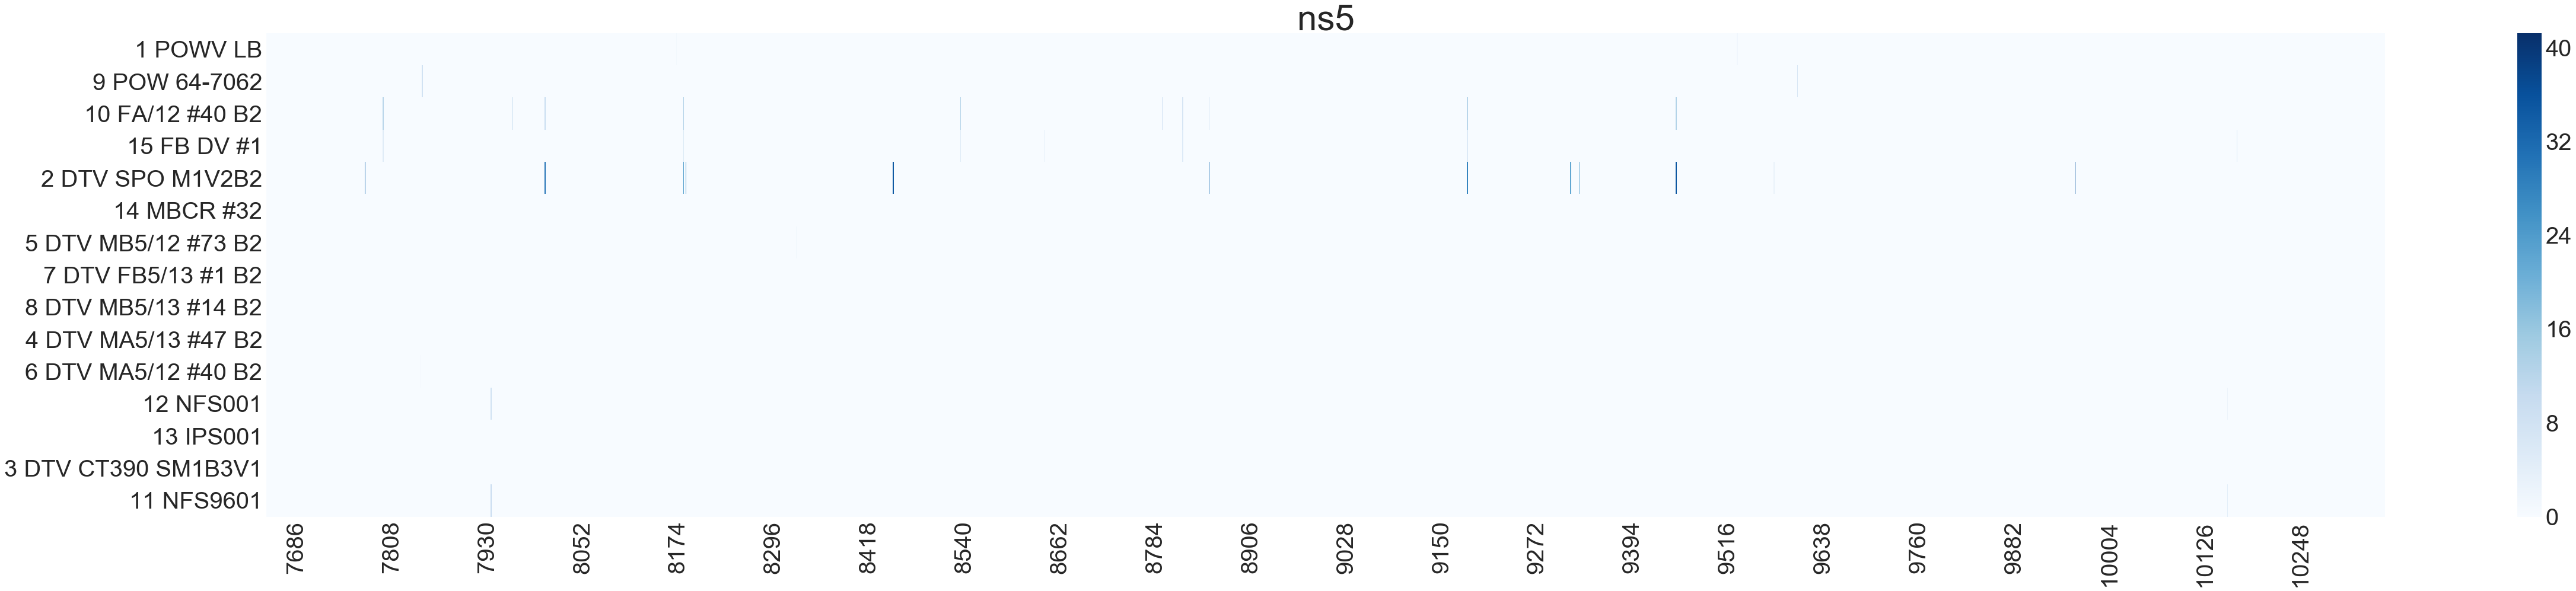

In [48]:
heatmap_isnvs(freq_df,gene_range=(7648,10356),title='ns5',size=(80,15))

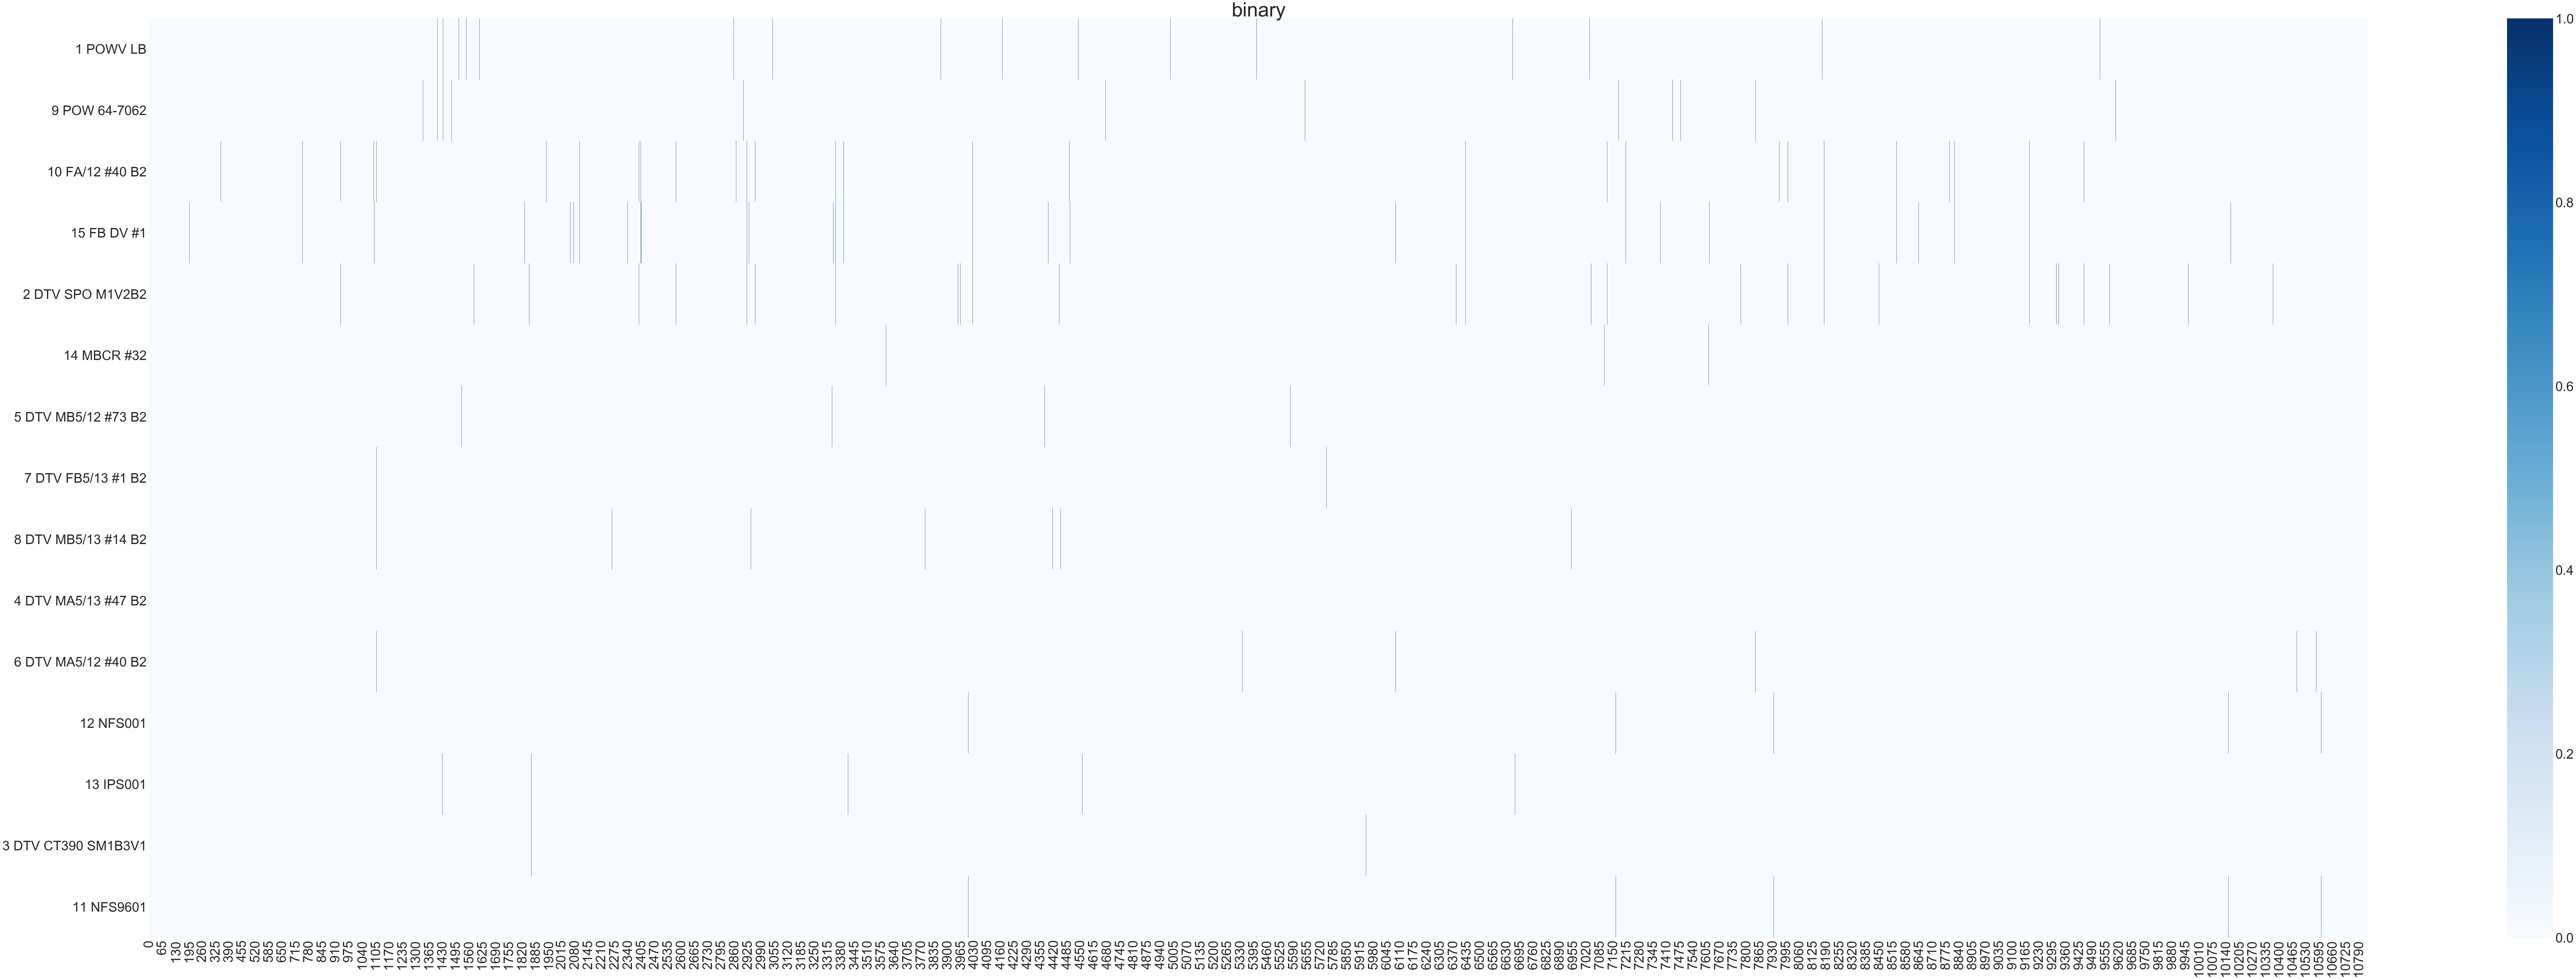

In [56]:
# I also want to look at just a binary visual of where the snps occur across genomes
#heatmap_isnvs(binary_df,gene_range=(0,10839),title='all isnvs',size=(120,30))

heatmap_isnvs(binary_df,gene_range=(0,10839),title='binary',size=(150,50))

## Exploring iSNV burden by POWV features
Note: this is a work in progress and I'm still playing around but here's some ideas

### iSNV by gene

In [50]:
# these lines calculate the frequency of mutation (# of mutations in a gene/size of gene)
proteinc = pd.Series(freq_df.iloc[:,112:441].astype(bool).sum(axis=1)/(441-112)*100, name = 'protein C')
preM = pd.Series(freq_df.iloc[:,442:945].astype(bool).sum(axis=1)/(945-442)*100, name = 'preM')
envelope = pd.Series(freq_df.iloc[:,946:2436].astype(bool).sum(axis=1)/(2436-946)*100, name = 'envelope')
ns1 = pd.Series(freq_df.iloc[:,2436:3495].astype(bool).sum(axis=1)/(3495-2436)*100, name = 'ns1')
ns2a = pd.Series(freq_df.iloc[:,3496:4185].astype(bool).sum(axis=1)/(4185-3496)*100, name = 'ns2a')
ns2b = pd.Series(freq_df.iloc[:,4186:4578].astype(bool).sum(axis=1)/(4578-4186)*100, name = 'ns2b')
ns3 = pd.Series(freq_df.iloc[:,4579:6444].astype(bool).sum(axis=1)/(6444-4579)*100, name = 'ns3')
ns4a = pd.Series(freq_df.iloc[:,6445:6822].astype(bool).sum(axis=1)/(6822-6445)*100, name = 'ns4a')
twok = pd.Series(freq_df.iloc[:,6823:6891].astype(bool).sum(axis=1)/(6891-6823)*100, name = '2k')
ns4b = pd.Series(freq_df.iloc[:,6892:7647].astype(bool).sum(axis=1)/(7647-6892)*100, name='ns4b')
ns5 = pd.Series(freq_df.iloc[:,7648:10356].astype(bool).sum(axis=1)/(10356-7648)*100, name='ns5')
# I'm also calculating the average frequency of iSNV across the whole virus
avg = pd.Series(freq_df.astype(bool).sum(axis=1)/10839*100, name = 'average')

mut_freq_bygene = pd.concat([proteinc,preM,envelope,ns1,ns2a,ns2b,ns3,ns4a,twok,ns4b,ns5,avg], axis=1)

In [51]:
# let's inspect the mutation frequencies by gene
mut_freq_bygene

,protein C,preM,envelope,ns1,ns2a,ns2b,ns3,ns4a,2k,ns4b,ns5,average
1 POWV LB,0.000000,0.000000,0.469799,0.283286,0.290276,0.255102,0.107239,0.265252,0.0,0.132450,0.073855,0.184519
9 POW 64-7062,0.000000,0.000000,0.268456,0.188857,0.000000,0.000000,0.107239,0.000000,0.0,0.529801,0.073855,0.129163
10 FA/12 #40 B2,0.303951,0.397614,0.469799,0.566572,0.145138,0.255102,0.107239,0.265252,0.0,0.264901,0.369276,0.304456
15 FB DV #1,0.303951,0.198807,0.536913,0.472144,0.145138,0.510204,0.160858,0.000000,0.0,0.397351,0.258493,0.286004
2 DTV SPO M1V2B2,0.000000,0.198807,0.268456,0.377715,0.435414,0.255102,0.268097,0.265252,0.0,0.264901,0.443131,0.313682
14 MBCR #32,0.000000,0.000000,0.000000,0.000000,0.145138,0.000000,0.000000,0.000000,0.0,0.264901,0.000000,0.027678
5 DTV MB5/12 #73 B2,0.000000,0.000000,0.067114,0.094429,0.000000,0.255102,0.053619,0.000000,0.0,0.000000,0.036928,0.046130
7 DTV FB5/13 #1 B2,0.000000,0.000000,0.067114,0.094429,0.000000,0.000000,0.107239,0.000000,0.0,0.000000,0.000000,0.036904
8 DTV MB5/13 #14 B2,0.000000,0.000000,0.134228,0.188857,0.290276,0.765306,0.053619,0.000000,0.0,0.132450,0.000000,0.101485
4 DTV MA5/13 #47 B2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


Below, for each sample, I'm plotting the frequency of mutation for each gene. I'm also plotting the average frequency of mutation across the whole genome, for comparison. The L2b strains (in blue) appear to have a lower average frequency of iSNV, and a few of the L2a strains have a very high average frequency of mutation. We could dig deeper to see if the mutation frequency in any gene is statistically significantly higher, but nothing really jumps out from this plot.

Text(0,0.5,'% isnv frequency')

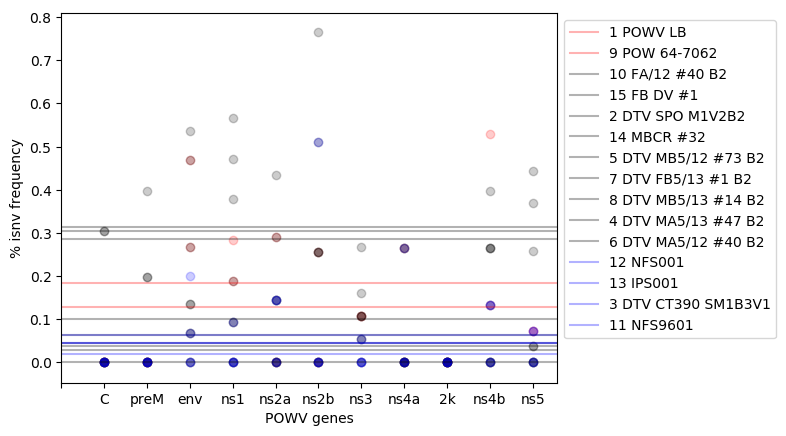

In [52]:
# I have to restructure the legend and colormap for this since we changed the order of samples to cluster by lineage
sns.reset_orig()
colormap = ['red','red','black','black','black','black','black','black',
            'black','black','black','blue','blue','blue','blue',]
legend = ['1 POWV LB','9 POW 64-7062','10 FA/12 #40 B2','15 FB DV #1','2 DTV SPO M1V2B2','14 MBCR #32','5 DTV MB5/12 #73 B2',
          '7 DTV FB5/13 #1 B2','8 DTV MB5/13 #14 B2','4 DTV MA5/13 #47 B2','6 DTV MA5/12 #40 B2',
          '12 NFS001','13 IPS001','3 DTV CT390 SM1B3V1','11 NFS9601']
# set the figure size
for i in range(15):
    plt.scatter([1,2,3,4,5,6,7,8,9,10,11],mut_freq_bygene.iloc[i,:11],alpha=.2,color=colormap[i])
    plt.axhline(y=mut_freq_bygene.iloc[i,11], color=colormap[i], linestyle='-',alpha=.3)
plt.legend(legend, bbox_to_anchor=(1,1))
plt.xticks(np.arange(12), ('', 'C', 'preM', 'env', 'ns1','ns2a','ns2b','ns3','ns4a','2k','ns4b','ns5'))
plt.xlabel('POWV genes')
plt.ylabel('% isnv frequency')

Now let's just plot normalized mutational frequency and have each sample be a distinct color

Text(0,0.5,'% isnv frequency - normalized by sample average')

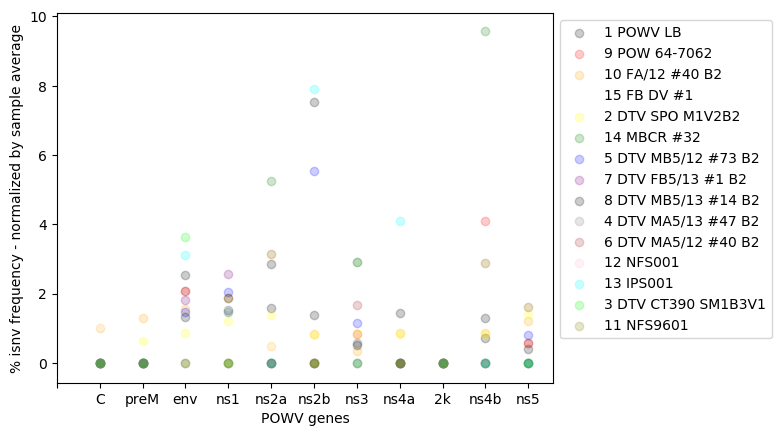

In [53]:
mut_freq_bygene_norm = mut_freq_bygene.div(mut_freq_bygene['average'], axis=0)
colormap = ['black','red','orange','white','yellow','green','blue','purple',
            'black','grey','brown','pink','aqua','lime','olive']

for i in range(15):
    plt.scatter([1,2,3,4,5,6,7,8,9,10,11],mut_freq_bygene_norm.iloc[i,:11],alpha=.2,color=colormap[i])
plt.legend(legend, bbox_to_anchor=(1,1))
plt.xticks(np.arange(12), ('', 'C', 'preM', 'env', 'ns1','ns2a','ns2b','ns3','ns4a','2k','ns4b','ns5'))
plt.xlabel('POWV genes')
plt.ylabel('% isnv frequency - normalized by sample average')

### iSNV by structural vs. nonstructural 

In [59]:
s = pd.Series(freq_df.iloc[:,112:2436].astype(bool).sum(axis=1)/(2436-112), name = 'structural')
ns = pd.Series(freq_df.iloc[:,2436:10356].astype(bool).sum(axis=1)/(10356-2436), name = 'nonstructural')
avg = pd.Series(freq_df.astype(bool).sum(axis=1)/10839, name = 'average')
mut_freq_by_s = pd.concat([s,ns,avg], axis=1)

In [60]:
# Here I'm plotting the frequency of iSNV in the structural genes as well as nonstructural, 
# normalized by average for each sample 
mut_freq_by_s.div(mut_freq_by_s['average'],axis=0)

,structural,nonstructural,average
1 POWV LB,1.632380,0.821136,1.0
9 POW 64-7062,1.332555,0.977543,1.0
10 FA/12 #40 B2,1.413316,0.953845,1.0
15 FB DV #1,1.504497,0.927089,1.0
2 DTV SPO M1V2B2,0.685874,1.127050,1.0
14 MBCR #32,0.000000,1.368561,1.0
5 DTV MB5/12 #73 B2,0.932788,1.094848,1.0
7 DTV FB5/13 #1 B2,1.165985,1.026420,1.0
8 DTV MB5/13 #14 B2,0.847989,1.119731,1.0
4 DTV MA5/13 #47 B2,NaN,NaN,NaN


## Exploring iSNVs that occur in multiple samples

If we look only at the basepairs for which there is an iSNV, we see that they often co-occur in two or more samples

In [61]:
# here we subset the dataframe to only show basepairs at which there is an iSNV in at least one sample 
# the columns are named with the bp position and the rows are unique samples
only_isnv_df = freq_df.loc[:, (freq_df != 0).any(axis=0)]
print("There are {} unique positions that have a nucleotide mutation across all samples".format(len(list(only_isnv_df))))
only_isnv_df

There are 137 unique positions that have a nucleotide mutation across all samples


,198,351,750,936,1092,1098,1101,1111,1324,1339,...,9575,9605,9960,10155,10167,10373,10403,10490,10584,10609
1 POWV LB,0.0000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000,1.77023,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,8.41499,0.00,0.00000,0.00000
9 POW 64-7062,0.0000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,3.15297,...,0.00000,6.36917,0.0000,0.00000,0.00000,0.0000,0.00000,0.00,0.00000,0.00000
10 FA/12 #40 B2,0.0000,13.5764,12.21530,12.7334,0.00000,13.1554,0.00000,2.07027,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00,0.00000,0.00000
15 FB DV #1,5.6309,0.0000,7.45819,0.0000,0.00000,0.0000,7.14247,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,6.06152,0.0000,0.00000,0.00,0.00000,0.00000
2 DTV SPO M1V2B2,0.0000,0.0000,0.00000,33.3535,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,...,2.92553,0.00000,34.4453,0.00000,0.00000,31.7503,0.00000,0.00,0.00000,0.00000
14 MBCR #32,0.0000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00,0.00000,0.00000
5 DTV MB5/12 #73 B2,0.0000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00,0.00000,0.00000
7 DTV FB5/13 #1 B2,0.0000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,2.48512,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00,0.00000,0.00000
8 DTV MB5/13 #14 B2,0.0000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,1.14085,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00,0.00000,0.00000
4 DTV MA5/13 #47 B2,0.0000,0.0000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00,0.00000,0.00000


In [62]:
# I'll now subset just the positions for which there are iSNVs for multiple samples
mult_isnv_idx = []
for bp in list(only_isnv_df):
    tally = 0
    for j in range(len(only_isnv_df)):
        if only_isnv_df[bp][j] != 0:
            tally += 1
    if tally > 1:
        mult_isnv_idx.append(bp)
print("There are {} unique positions that have a nucleotide mutation in multiple samples".format(len(list(only_isnv_df[mult_isnv_idx]))))
only_isnv_df[mult_isnv_idx]

There are 35 unique positions that have a nucleotide mutation in multiple samples


,750,936,1111,1408,1436,1860,1868,2103,2393,2403,...,7935,8004,8181,8535,8819,8853,9183,9450,10155,10609
1 POWV LB,0.00000,0.0000,0.00000,1.72124,3.11369,0.0000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000
9 POW 64-7062,0.00000,0.0000,0.00000,28.54410,19.86620,0.0000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000
10 FA/12 #40 B2,12.21530,12.7334,2.07027,0.00000,0.00000,12.4123,0.00000,14.96920,11.5246,11.56550,...,0.0000,9.76164,12.77680,12.18950,7.02586,7.18772,12.24760,12.8620,0.00000,0.00000
15 FB DV #1,7.45819,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,1.60973,0.0000,9.04091,...,0.0000,0.00000,5.57542,4.91824,5.46439,0.00000,5.72025,0.0000,0.00000,0.00000
2 DTV SPO M1V2B2,0.00000,33.3535,0.00000,0.00000,0.00000,28.6708,0.00000,0.00000,28.4511,0.00000,...,0.0000,30.65480,22.80310,0.00000,0.00000,30.47120,27.95920,35.0049,0.00000,0.00000
14 MBCR #32,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000
5 DTV MB5/12 #73 B2,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000
7 DTV FB5/13 #1 B2,0.00000,0.0000,2.48512,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000
8 DTV MB5/13 #14 B2,0.00000,0.0000,1.14085,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000
4 DTV MA5/13 #47 B2,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000


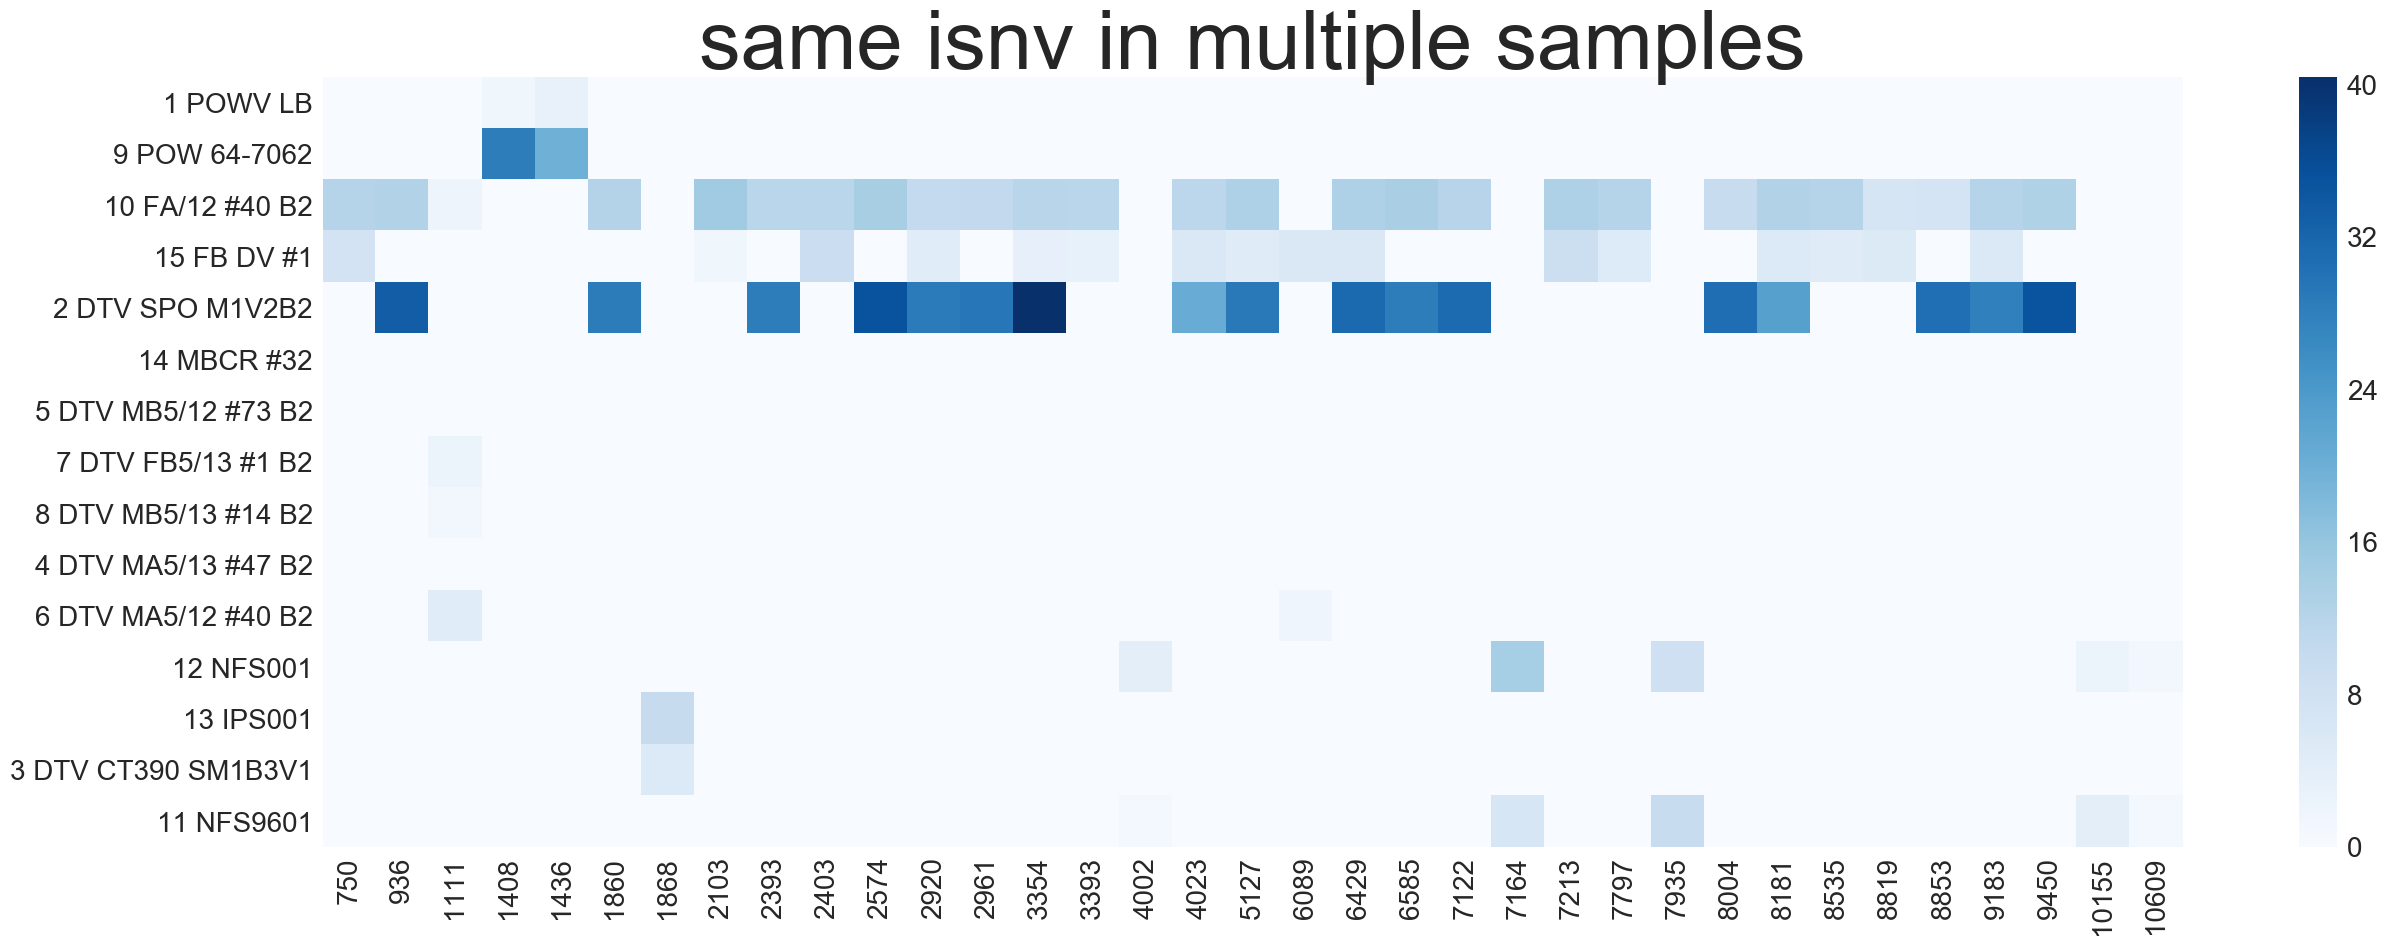

In [67]:
sns.set(font_scale=2) 
heatmap_isnvs(only_isnv_df[mult_isnv_idx],gene_range=(0,35),title='same isnv in multiple samples',size=(30,10))

In [68]:
# we can get the same subset of columns for the minor and major isnv tables so that we can see
# if the substitutions are the same across samples
minor_df[mult_isnv_idx]

,750,936,1111,1408,1436,1860,1868,2103,2393,2403,...,7935,8004,8181,8535,8819,8853,9183,9450,10155,10609
0,0.0,0.0,0.0,A,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,A,G,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,T,T,G,0.0,0.0,T,0.0,A,C,T,...,0.0,T,T,T,A,A,T,A,0.0,0.0
3,T,0.0,0.0,0.0,0.0,0.0,0.0,G,0.0,T,...,0.0,0.0,C,C,G,0.0,C,0.0,0.0,0.0
4,0.0,C,0.0,0.0,0.0,C,0.0,0.0,T,0.0,...,0.0,A,C,0.0,0.0,G,C,G,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
major_df[mult_isnv_idx]

,750,936,1111,1408,1436,1860,1868,2103,2393,2403,...,7935,8004,8181,8535,8819,8853,9183,9450,10155,10609
0,0.0,0.0,0.0,G,G,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,G,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,G,C,A,0.0,0.0,C,0.0,G,T,C,...,0.0,A,C,C,G,G,C,G,0.0,0.0
3,G,0.0,0.0,0.0,0.0,0.0,0.0,A,0.0,C,...,0.0,0.0,T,T,A,0.0,T,0.0,0.0,0.0
4,0.0,T,0.0,0.0,0.0,T,0.0,0.0,C,0.0,...,0.0,T,T,0.0,0.0,A,T,A,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploring amino acid changes resulting from iSNVS
Erica's code here isn't particularly efficient

In [70]:
# making sure we have biopython - importing some useful things
import sys
!conda install --yes --prefix {sys.prefix} numpy
import Bio
print(Bio.__version__)
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

Solving environment: done

## Package Plan ##

  environment location: /anaconda3

  added / updated specs: 
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.2                |           py36_0         1.6 MB

The following packages will be UPDATED:

    conda: 4.5.12-py36_0 --> 4.6.2-py36_0


conda-4.6.2          | 1.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
1.73


### Importing and formatting data

Make sure to keep multifasta file you're importing is in same order as we imported initially (alphanumeric)- at least until I find a way around that. Also, I added the appropriate number of N's to be sure that the sequences lined up to the reference from the beginning (this is important to ensure the bp calls are in the right place and getting all sequences in the same frame)

In [81]:
# here we're importing sequences in the multifasta format into a dictionary
seq_dict = dict()
for seq_record in SeqIO.parse("./Desktop/CSU_gcloud_multifasta.fasta", "fasta"):
    seq_dict[seq_record.id] = (seq_record.seq)

In [82]:
# this chunk is to get a list of isnvs position for each sample - there's probably better ways to do this 
# (e.g. working off the original dictionary of vphaser reports) but this will do
cols = freq_df.columns
bt = freq_df.apply(lambda x: x > 0)
isnv_bp_by_sample = bt.apply(lambda x: list(cols[x.values]), axis=1)

# this makes a sequence demonstrating all the minor isnv variants and makes a sequence with all major isnv variants
# note major isnv variants sequence should be the same as the consensus, but just in case, we'll check it
minor_seq_dict = seq_dict.copy()
major_seq_dict = seq_dict.copy()
for i,key in zip(range(len(minor_seq_dict)),minor_seq_dict):
    for bp in isnv_bp_by_sample[i]:
        minor_seq_dict[key] = minor_seq_dict[key][:(bp-1)] + minor_df[bp][i] + minor_seq_dict[key][bp:]
        major_seq_dict[key] = major_seq_dict[key][:(bp-1)] + major_df[bp][i] + major_seq_dict[key][bp:]

# translate to confirm we're in the right frame - we are
seq_dict['CSUcx1-1_gcloud_new'].translate()

Seq('XFSCTCVRVL*SVSAAFC*T*VC*EKDSLGEQELGVVMMTTSKGKGGGPPRRKL...XXX', HasStopCodon(ExtendedIUPACProtein(), '*'))

In [113]:
# now translate all sequences so we can compare them
minor_trans_dict = dict()
major_trans_dict = dict()
trans_dict = dict()
for key in seq_dict:
    minor_trans_dict[key] = minor_seq_dict[key].translate()
    major_trans_dict[key] = major_seq_dict[key].translate()
    trans_dict[key] = seq_dict[key].translate()

# this checks for differences between the consensus and the sequences filled with major isnv variant
# these should be identical, but it's a good check
for key in trans_dict:
    print(key)
    for i in range(len(str(trans_dict[key]))):
        if trans_dict[key][i] != major_trans_dict[key][i]:
            print(i)
            print(trans_dict[key][i])
            print(major_trans_dict[key][i])

CSUcx1-1_gcloud_new
CSUcx9-1_gcloudnew
CSUcx10-1_gcloud_new
CSUcx15-1_gcloudnew
CSUcx2-1_gcloudnew
CSUcx14-1_gcloudnew
CSUcx5-1_gcloudnew
CSUcx7-1_gcloudnew
CSUcx8-1_gcloudnew
CSUcx4-1_gcloudnew
CSUcx6-1_gcloudnew
CSUcx12-1_gcloudnew
CSUcx13-1_gcloudnew
CSUcx3-1_gcloudnew
CSUcx11-1_gcloudnew


/anaconda3/lib/python3.6/site-packages/Bio/Seq.py:2609: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [114]:
# Now we'll look at minor vs. major to see which isnvs result in aa change
# I'm also writing this info to a dataframe to make a heatmap like we did before

#aa_change_df = pd.DataFrame(np.zeros((15,10839)))
aa_change_df = pd.DataFrame(np.zeros((15,3613)))

for j,key in zip(range(len(major_trans_dict)),major_trans_dict):
    #print(key)
    for i in range(len(str(major_trans_dict[key]))):
        if minor_trans_dict[key][i] != major_trans_dict[key][i]:
            tally += 1
            #aa_change_df[i*3][j] = 1
            aa_change_df[i][j] = 1
            #print(i)
            #print(minor_trans_dict[key][i])
            #print(major_trans_dict[key][i])
    
aa_change_df = aa_change_df.rename(index={0:'1 POWV LB',1:'9 POW 64-7062',2:'10 FA/12 #40 B2',3:'15 FB DV #1',
                                4:'2 DTV SPO M1V2B2',5:'14 MBCR #32',6:'5 DTV MB5/12 #73 B2',
                                7:'7 DTV FB5/13 #1 B2',8:'8 DTV MB5/13 #14 B2',9:'4 DTV MA5/13 #47 B2',
                                10:'6 DTV MA5/12 #40 B2', 11:'12 NFS001',12:'13 IPS001',
                                13:'3 DTV CT390 SM1B3V1',14:'11 NFS9601'})

In [115]:
aa_change_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3603,3604,3605,3606,3607,3608,3609,3610,3611,3612
1 POWV LB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9 POW 64-7062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 FA/12 #40 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15 FB DV #1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2 DTV SPO M1V2B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


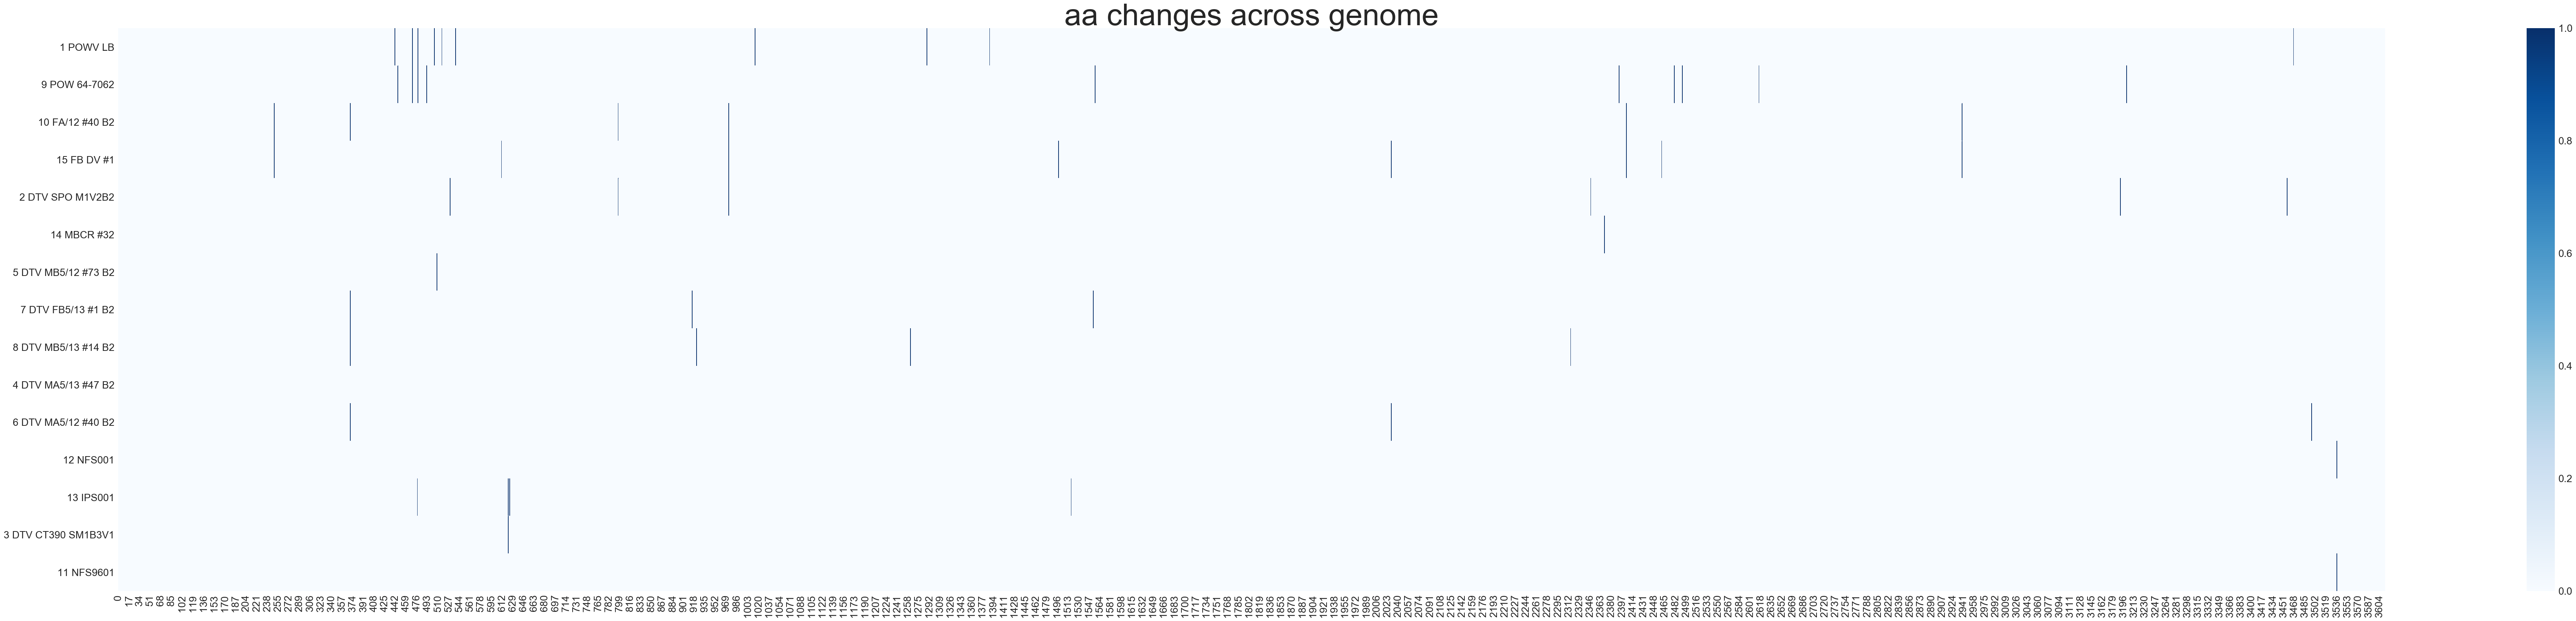

In [116]:
heatmap_isnvs(aa_change_df,gene_range=(0,3613),title='aa changes across genome',size=(100,20))

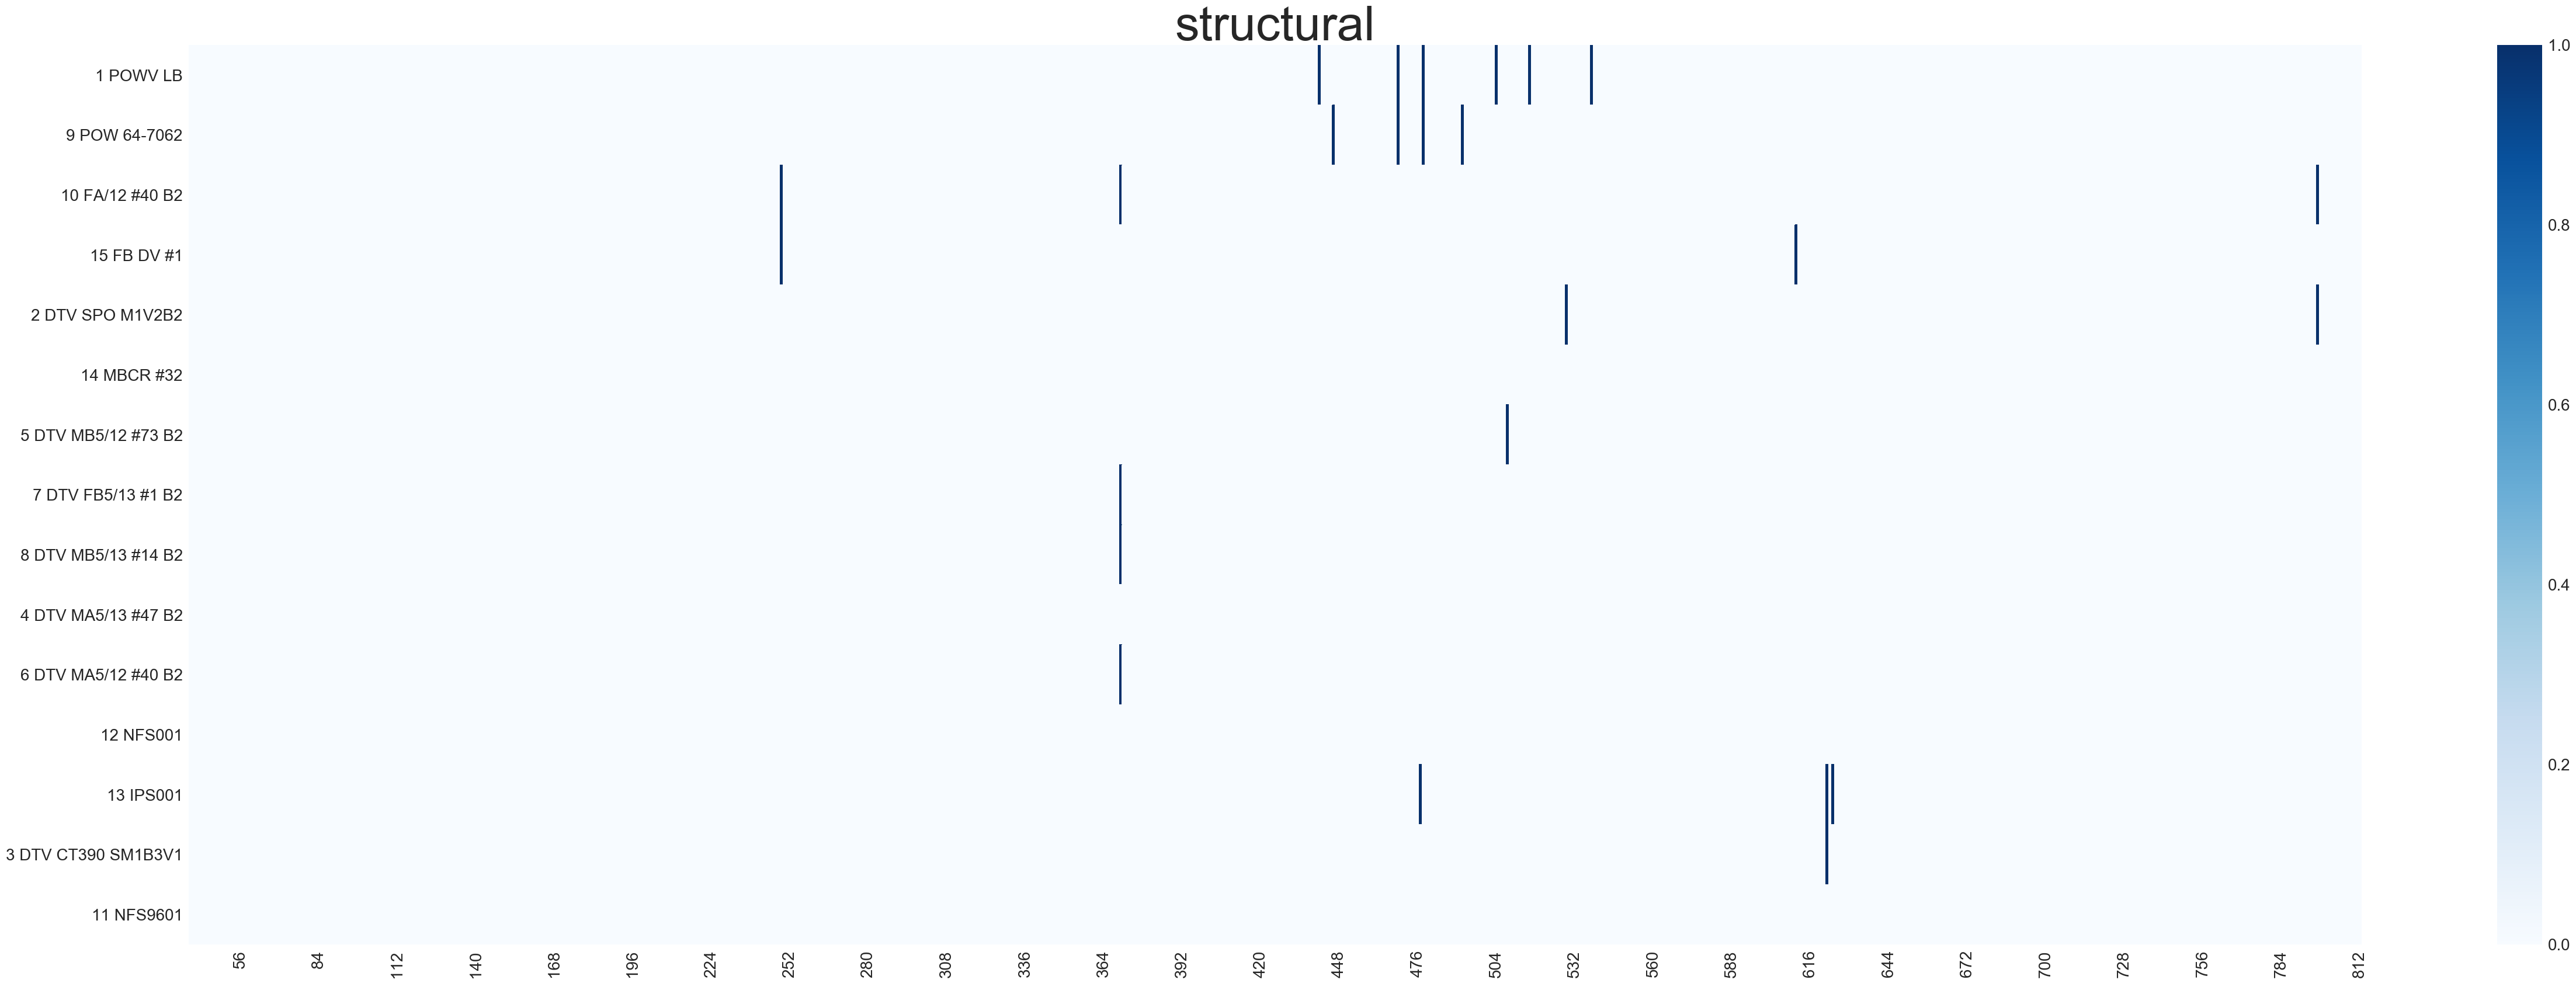

In [117]:
heatmap_isnvs(aa_change_df,gene_range=(38,813),title='structural',size=(60,20))

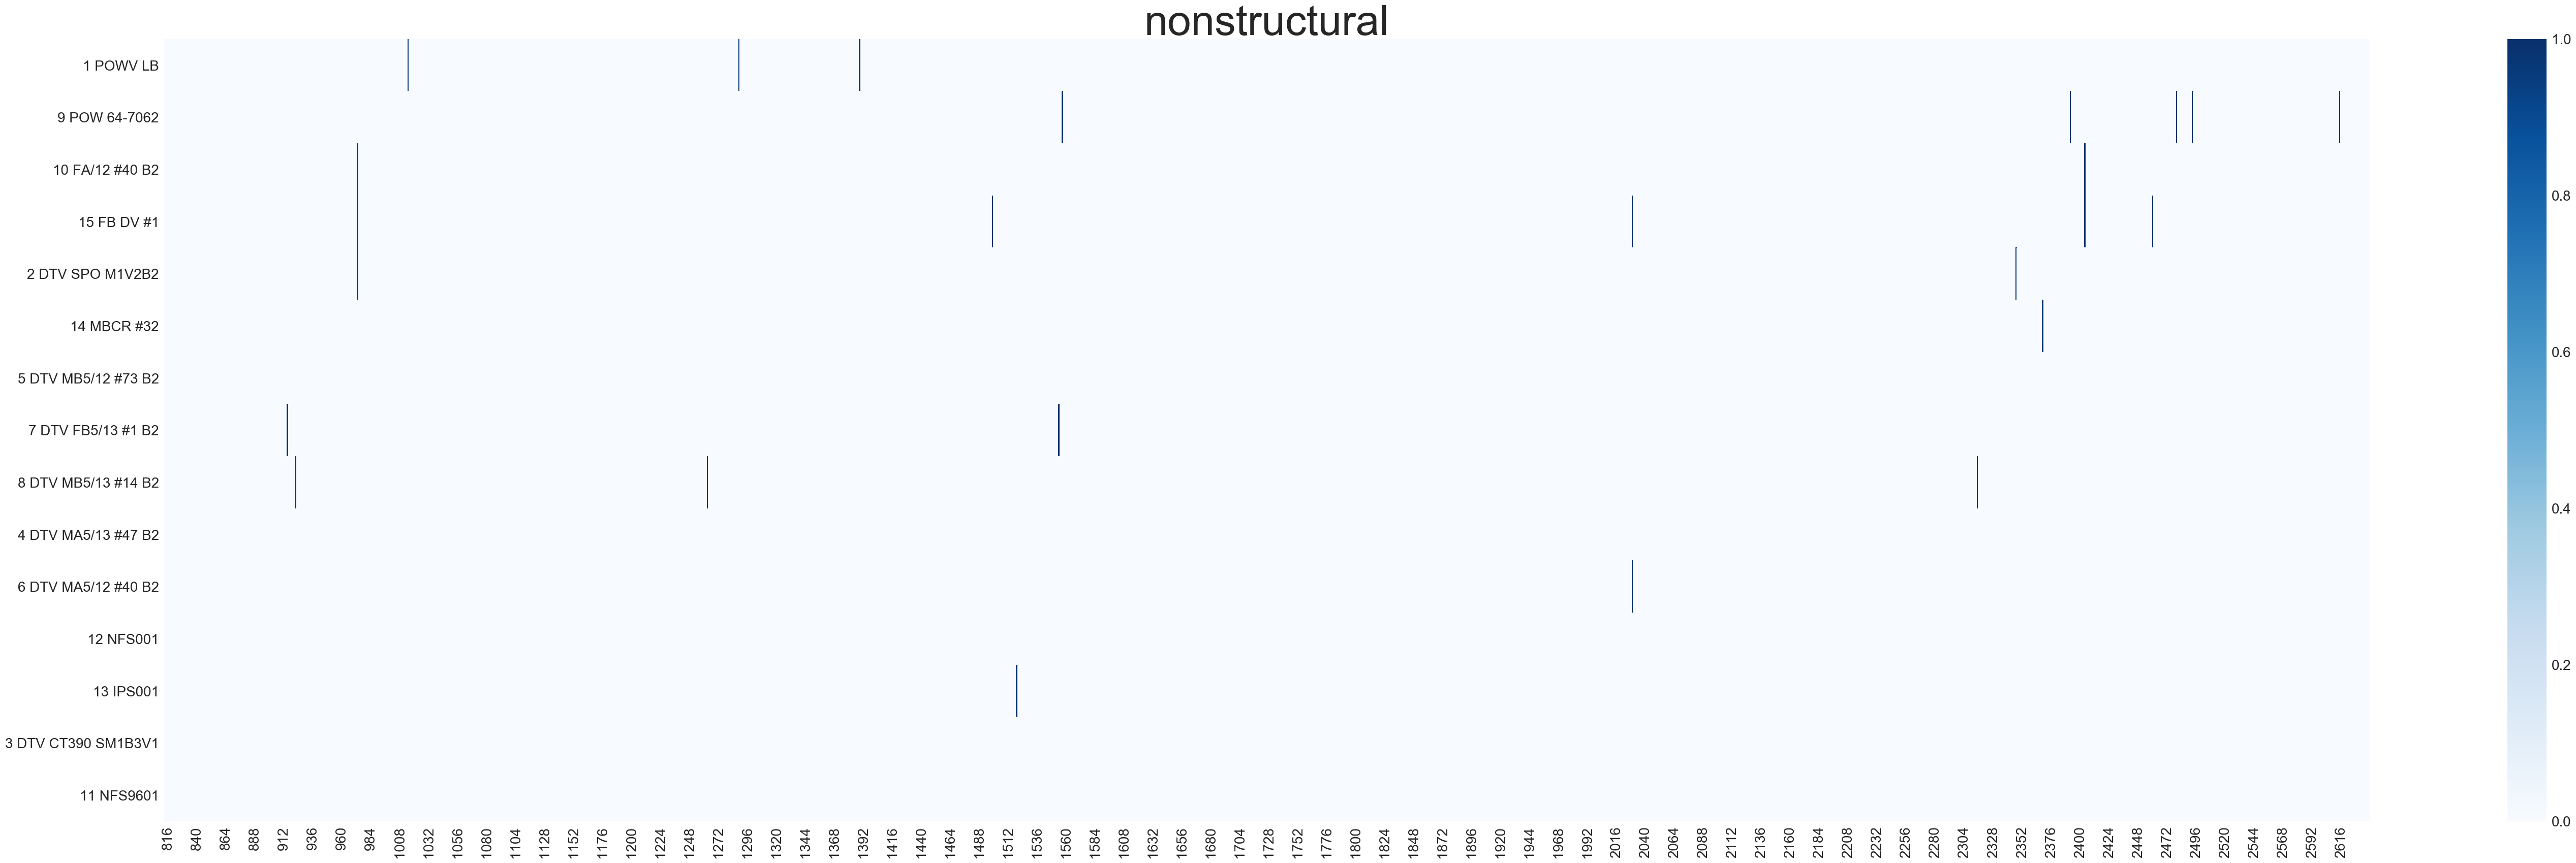

In [118]:
heatmap_isnvs(aa_change_df,gene_range=(813,2640),title='nonstructural',size=(70,20))

In [119]:
# how many residues are there in which isnv results in aa chang?
only_aa_df = aa_change_df.loc[:, (aa_change_df != 0).any(axis=0)]
print('There are {} unique residues that are mutated across all samples samples'.format(len(list(only_aa_df))))
only_aa_df

There are 45 unique residues that are mutated across all samples samples


,249,370,441,446,469,477,478,492,504,508,...,2480,2493,2615,2939,3191,3201,3457,3467,3496,3536
1 POWV LB,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9 POW 64-7062,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10 FA/12 #40 B2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15 FB DV #1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2 DTV SPO M1V2B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
14 MBCR #32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5 DTV MB5/12 #73 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7 DTV FB5/13 #1 B2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8 DTV MB5/13 #14 B2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 DTV MA5/13 #47 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
# I'll now subset just the positions for which there are iSNVs for multiple samples
mult_aa_idx = []
for aa in list(only_aa_df):
    tally = 0
    for j in range(len(only_aa_df)):
        if only_aa_df[aa][j] != 0:
            tally += 1
    if tally > 1:
        mult_aa_idx.append(aa)
print('There are {} unique residues that are mutated in multiple samples'.format(len(list(only_aa_df[mult_aa_idx]))))
only_aa_df[mult_aa_idx]

There are 11 unique residues that are mutated in multiple samples


,249,370,469,478,622,797,973,2029,2404,2939,3536
1 POWV LB,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9 POW 64-7062,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 FA/12 #40 B2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
15 FB DV #1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2 DTV SPO M1V2B2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
14 MBCR #32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5 DTV MB5/12 #73 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7 DTV FB5/13 #1 B2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8 DTV MB5/13 #14 B2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 DTV MA5/13 #47 B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
# calculate number of nonsynonymous changes
aa_change_df.astype(bool).sum(axis=1)

1 POWV LB              10
9 POW 64-7062          10
10 FA/12 #40 B2         6
15 FB DV #1             8
2 DTV SPO M1V2B2        6
14 MBCR #32             1
5 DTV MB5/12 #73 B2     1
7 DTV FB5/13 #1 B2      3
8 DTV MB5/13 #14 B2     4
4 DTV MA5/13 #47 B2     0
6 DTV MA5/12 #40 B2     3
12 NFS001               1
13 IPS001               4
3 DTV CT390 SM1B3V1     1
11 NFS9601              1
dtype: int64

In [125]:
# calculate number of synonymous changes
(freq_df.astype(bool).sum(axis=1))-(aa_change_df.astype(bool).sum(axis=1))

1 POWV LB              10
9 POW 64-7062           4
10 FA/12 #40 B2        27
15 FB DV #1            23
2 DTV SPO M1V2B2       28
14 MBCR #32             2
5 DTV MB5/12 #73 B2     4
7 DTV FB5/13 #1 B2      1
8 DTV MB5/13 #14 B2     7
4 DTV MA5/13 #47 B2     0
6 DTV MA5/12 #40 B2     4
12 NFS001               4
13 IPS001               3
3 DTV CT390 SM1B3V1     1
11 NFS9601              4
dtype: int64

In [126]:
# dS/dN
(freq_df.astype(bool).sum(axis=1)-(aa_change_df.astype(bool).sum(axis=1)))/freq_df.astype(bool).sum(axis=1)

1 POWV LB              0.500000
9 POW 64-7062          0.285714
10 FA/12 #40 B2        0.818182
15 FB DV #1            0.741935
2 DTV SPO M1V2B2       0.823529
14 MBCR #32            0.666667
5 DTV MB5/12 #73 B2    0.800000
7 DTV FB5/13 #1 B2     0.250000
8 DTV MB5/13 #14 B2    0.636364
4 DTV MA5/13 #47 B2         NaN
6 DTV MA5/12 #40 B2    0.571429
12 NFS001              0.800000
13 IPS001              0.428571
3 DTV CT390 SM1B3V1    0.500000
11 NFS9601             0.800000
dtype: float64